In [158]:
import sys
import os
import glob
%load_ext autoreload
%autoreload 2
import pylab as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
sys.path.append('/home/simon/git/pymzm')
sys.path.append('/home/simon/git/mass-spec-utils')

In [160]:
mzml_folder = '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/'
mzml_files = glob.glob(os.path.join(mzml_folder,'*.mzML'))
time_map = {0 : '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/0_pp_d20_pos_1.mzML',
            8 : '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/8_pp_d20_pos_1.mzML',
            48: '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/48_pp_d20_pos_1.mzML',
            72: '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/72_pp_d20_pos_1.mzML',
            96: '/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/96_pp_d20_.mzML'}

In [177]:
from Roi import make_roi
mz_units = 'ppm'
mz_tol = 10
min_length = 5
min_intensity = 100e3
max_gap_run = 1
all_rois = {}
for time,mzml_file in time_map.items():
    print(mzml_file)
    all_rois[time],junk = make_roi(mzml_file,
                         mz_tol = mz_tol,
                         mz_units = mz_units,
                         min_length = min_length,
                         min_intensity = min_intensity,
                         max_gap_run = max_gap_run)


/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/0_pp_d20_pos_1.mzML
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/8_pp_d20_pos_1.mzML
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/48_pp_d20_pos_1.mzML
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/72_pp_d20_pos_1.mzML
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/centroid/96_pp_d20_.mzML


In [178]:
from molmass import Formula
from Roi import roi_correlation
from adduct_rules import AdductTransformer
at = AdductTransformer()
ion_mode = 'Pos'
lipids = {'PC 34:1':('C42H82NO8P','C42H81DNO8P',760.5836,10.47*60,'[M+H]+'),
          'PC 34:2':('C42H80NO8P','C42H79DNO8P',758.5677,9.78*60.0,'[M+H]+'),
          'PC 34:0':('C42H84NO8P','C42H83DNO8P',762.5997,11.2*60.0,'[M+H]+'),
          'PC 34:0p':('C42H84NO7P','C42H83DNO7P',746.8044,11.03*60.0,'[M+H]+'),
          'PC 38:5p':('C43H76NO7P','C43H75DNO7P',750.5421,10.63*60.0,'[M+H]+'),
          'PC 38:4p':('C43H78NO7P','C43H77DNO7P',752.5577,11.3*60.0,'[M+H]+'),
         }

In [187]:
def get_correlators(roi,others,ppm = 20,max_iso_num = 6,thresh = 0.5):
    correlators = []
    PROTON_MASS = 1.00727645199076
    from Roi import roi_correlation
    for g in others:
        if g == roi:
            continue
        if g.get_mean_mz() < roi.get_mean_mz():
            continue
        found = False
        for i in range(1,max_iso_num+1):
            cand_mz = roi.get_mean_mz() + i*PROTON_MASS
            tol = 0.1
            if g.get_mean_mz() >= cand_mz - tol and g.get_mean_mz() <= cand_mz + tol:
                found = True
                iso = i
                break
        if not found:
            continue
        corr = roi_correlation(roi,g)
        if corr >= thresh:
            correlators.append((g,iso)) 
    return correlators

In [188]:
ppm = 10
candidate_rois = {}
for lipid,dets in lipids.items():
    f = Formula(dets[0])
    if ion_mode == 'Pos':
        mz = at.mass2ion(f.isotope.mass,dets[4])
    rt = dets[3]
    tol = ppm*mz/1e6
    candidate_rois[lipid] = {}
    for time in time_map:
        candidate_rois[lipid][time] = {}
        candidates = list(filter(lambda x: x.get_mean_mz() >= mz - tol and x.get_mean_mz() <= mz + tol
                                                  and abs(x.get_apex_rt() - rt) < 60,all_rois[time]))
        for roi in candidates:
            candidate_rois[lipid][time][roi] = get_correlators(roi,all_rois[time],ppm = 20)
        

For each lipid, we have candidate ROIs in each file

In [189]:
aligned_rois = {}
for lipid in lipids:
    aligned_rois[lipid] = {}
    print(lipid)
    # grab the time 0 ROIs
    roi_set = list(candidate_rois[lipid][0])
    
    for start_roi in roi_set:
        aligned_rois[lipid][start_roi] = {0:start_roi}
        for time in time_map:
            if time == 0:
                continue
            best = None
            best_overlap = 0
            for roi in candidate_rois[lipid][time]:
                overlap = time_overlap(start_roi,roi)
                if overlap > best_overlap:
                    best = roi
                    best_overlap = overlap
            aligned_rois[lipid][start_roi][time] = best
                    
print(aligned_rois['PC 34:0'])

PC 34:1
PC 34:2
PC 34:0
PC 34:0p
PC 38:5p
PC 38:4p
{ROI with data points=17 mz (762.5993-762.5992) rt (665.2980-678.3720): {0: ROI with data points=17 mz (762.5993-762.5992) rt (665.2980-678.3720), 8: ROI with data points=17 mz (762.5990-762.5989) rt (665.3160-678.3840), 48: ROI with data points=13 mz (762.5981-762.6016) rt (666.9660-676.7700), 72: ROI with data points=14 mz (762.5981-762.6015) rt (667.7940-678.4020), 96: ROI with data points=12 mz (762.5985-762.6019) rt (667.9320-676.9440)}}


In [207]:
lipid = 'PC 38:4p'
n_times = len(time_map)
print(len(aligned_rois[lipid].keys()))
start_roi = list(aligned_rois[lipid].keys())[0]
max_iso = len(candidate_rois[lipid][0][start_roi])
max_iso = 0
for time,roi in aligned_rois[lipid][start_roi].items():
    n_iso = max([i for g,i in candidate_rois[lipid][time][roi]])
    max_iso = max(max_iso,n_iso)
print(max_iso)
n_iso = max_iso + 1

import numpy as np
data_mat = np.zeros((n_times,n_iso))
time_pos = 0

time_list = [0,8,48,72,96]
for time in time_list:
    roi = aligned_rois[lipid][start_roi][time]
    data_mat[time_pos,0] = roi.get_max_intensity()
    scan_no = roi.get_apex_scan_no()
    for other,iso_num in candidate_rois[lipid][time][roi]:
#         pos = other.scan_n_list.index(scan_no)
#         data_mat[time_pos,iso_num] = other.intensity_list[pos]
          data_mat[time_pos,iso_num] = other.get_max_intensity()
    time_pos += 1
data_mat /= data_mat.sum(axis=1)[:,None]
plt.imshow(data_mat,aspect='auto')
plt.figure()
p = fit(time_list,data_mat,make_plot = True)
print(p)

plt.figure()
for t,r in aligned_rois[lipid][start_roi].items():
    print(t,r)
    plt.plot(r.rt_list,r.intensity_list,label = t)
plt.legend()

3


ValueError: max() arg is an empty sequence

In [208]:
print(candidate_rois[lipid][time])
print(lipid,time)
PROTON_MASS = 1.00727645199076
print(Formula('C43H78NO7P').isotope.mass + PROTON_MASS)
print(11.3*60.0)

{ROI with data points=10 mz (752.5558-752.5523) rt (633.7560-641.0520): [(ROI with data points=5 mz (753.5607-753.5572) rt (635.3760-638.6160), 1)], ROI with data points=6 mz (752.5591-752.5591) rt (668.7420-674.4720): [], ROI with data points=6 mz (752.5591-752.5592) rt (681.0480-685.1700): []}
PC 38:4p 96
752.5588673057707
678.0


(ROI with data points=8 mz (763.5984-763.5984) rt (582.4680-588.1398), 5)
(ROI with data points=14 mz (762.5909-762.5909) rt (580.8384-591.3816), 4)
(ROI with data points=8 mz (767.5772-767.5773) rt (588.1398-593.8188), 9)
(ROI with data points=10 mz (766.5724-766.5725) rt (588.1398-595.4478), 8)
(ROI with data points=30 mz (761.5855-761.5855) rt (580.0212-603.5880), 3)
(ROI with data points=41 mz (760.5783-760.5784) rt (579.2034-611.7420), 2)
(ROI with data points=50 mz (759.5732-759.5663) rt (579.2034-619.8660), 1)
ROI with data points=41 mz (760.5783-760.5784) rt (579.2034-611.7420)
ROI with data points=41 mz (760.5854-760.5854) rt (617.4360-649.8720)
ROI with data points=10 mz (760.6418-760.6417) rt (671.0340-678.4080)
ROI with data points=21 mz (760.6206-760.6211) rt (679.2240-695.6940)


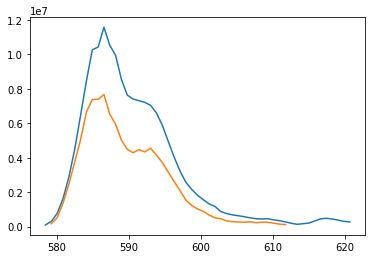

In [184]:
ro = aligned_rois[lipid][start_roi][48]
for r in candidate_rois[lipid][48][ro]:
    print(r)
possibles = list(filter(lambda x: x.get_mean_mz()>760 and x.get_mean_mz() < 761,all_rois[48]))
for p in possibles:
    print(p)
p = possibles[0]
roi_correlation(ro,p)
plt.plot(ro.rt_list,ro.intensity_list)
plt.plot(p.rt_list,p.intensity_list)

In [185]:
def time_overlap(roi1,roi2):
    start_time = sorted([roi1.rt_list[0],roi2.rt_list[0]])
    end_time = sorted([roi1.rt_list[-1],roi2.rt_list[-1]])
    overlap = (end_time[0] - start_time[1])/(end_time[1] - start_time[0])
    return overlap
    

In [75]:
from scipy.optimize import minimize
def min_func(x,*args):
    # x = k: the rate constant
    # *args
    p = args
    if p[0] == True:
        # fix ends is true - fix the end points from the data - not recommended
        t = p[1]
        data = p[2]
        a0 = p[3]
        ai = p[4]
        
        k = x[0]
    else:
        t = p[1]
        data = p[2]
        
        k = x[0]
        a0 = x[1]
        ai = x[2]

    preds = a0 + (ai-a0)*(1-np.exp(-k*t))
    return ((preds-data)**2).sum()


def fit(times,data_mat,fix_ends = True,make_plot = True,options = {},method = 'L-BFGS-B'):

    t = np.array(times)
    
    a0 = data_mat[0,0]
    ai = data_mat[-1,0]
        
    k = 0.05
    
    if fix_ends:
        args = (fix_ends,t,data_mat[:,0],a0,ai)
        zinit = [k]
    else:
        args = (fix_ends,t,data_mat[:,0])
        zinit = [k,a0,ai]
    
    end = minimize(min_func,zinit,args = args,method = method)
    
    if fix_ends:
        k = end['x'][0]
    else:
        k = end['x'][0]
        a0 = end['x'][1]
        ai = end['x'][2]
    
    if make_plot:
        plt.figure()
        plt.plot(t,data_mat[:,0],'ro')
        plt.plot(t,a0 + (ai-a0)*(1-np.exp(-k*t)))
    
    return (k,a0,ai)

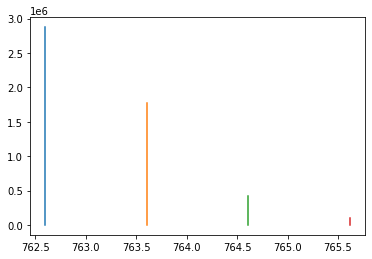

In [38]:
roi = candidate_rois[0]
plt.figure()
plt.plot([roi.get_mean_mz(),roi.get_mean_mz()],[0,roi.get_max_intensity()])
for g in correlators[roi]:
    plt.plot([g.get_mean_mz(),g.get_mean_mz()],[0,g.get_max_intensity()])

In [28]:
for g in correlators[roi]:
    print(g)

ROI with data points=43 mz (747.6091-747.6090) rt (650.6760-684.9360)
ROI with data points=34 mz (748.6110-748.6110) rt (653.9340-680.8320)
ROI with data points=22 mz (749.6116-749.6150) rt (655.5660-673.4700)
ROI with data points=8 mz (750.6280-750.6281) rt (657.1980-662.8800)


In [29]:
gg = list(filter(lambda x: x.get_mean_mz() > 748.5 and x.get_mean_mz() < 748.62,good))
for g in gg:
    print(g)
g = gg[-1]
roi_correlation(roi,g)

ROI with data points=12 mz (748.5113-748.5111) rt (563.7408-575.1342)
ROI with data points=21 mz (748.5119-748.5120) rt (539.8422-557.1738)
ROI with data points=12 mz (748.5190-748.5189) rt (523.3362-532.4142)
ROI with data points=15 mz (748.5250-748.5286) rt (615.0000-626.3580)
ROI with data points=14 mz (748.5363-748.5363) rt (343.4232-354.9768)
ROI with data points=5 mz (748.5396-748.5431) rt (1305.5400-1310.4960)
ROI with data points=15 mz (748.5399-748.5399) rt (198.1770-212.2068)
ROI with data points=62 mz (748.5501-748.5501) rt (369.8328-421.0002)
ROI with data points=67 mz (748.5499-748.5466) rt (437.5056-497.7516)
ROI with data points=9 mz (748.5497-748.5499) rt (511.7814-519.2100)
ROI with data points=14 mz (748.5501-748.5466) rt (423.4758-434.2044)
ROI with data points=5 mz (748.5501-748.5501) rt (359.1036-362.4054)
ROI with data points=10 mz (748.5765-748.5736) rt (685.7640-694.0140)
ROI with data points=32 mz (748.5767-748.5766) rt (588.9492-614.1900)
ROI with data points=

0.9976721436340907